<a href="https://colab.research.google.com/github/jimmy-pink/colab-playground/blob/main/pre-trained/vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 使用VGG16预训练模型

### 需求描述

[💾 Google Drive：训练数据集](https://drive.google.com/drive/folders/1xwtf91GSyeIc7ohpCKsDCYv3zXgKa0sf)

有一批约800张文件夹图标的png图片，需要将这批图片分类：  

- 按形状分
  - 标准
  - 折叠1
  - 折叠2
  - 折叠3
  - 折叠4
  - 长方形-长
  - 长方形-短
  - 文件堆叠

简化问题：只分两种： 标准文件夹样式，  其他   
简化的二分类问题，也能够从大批量爬取图片中筛选较为优质的图标

#### 迭代训练（Iterative Training） + 主动学习（Active Learning）

主动学习（Active Learning）

- 核心思想：模型主动选择“最有价值”的数据（通常是难以分类的样本）进行标注，而非随机标注。
- 模型通过预测筛选出 False Positive（FP） 和 False Negative（FN） 的样本（即错误预测数据），人工修正标签后重新训练，属于主动学习的典型应用。


Bootstrapping（自举法）

- 通过迭代训练逐步提升模型性能，每一轮用当前模型预测未标注数据，筛选高置信度或易错样本加入训练集。

课程学习（Curriculum Learning）
- 从简单样本（少量初始数据）开始训练，逐步加入更难样本（错误预测数据）。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

import os
import shutil

In [16]:
from google.colab import drive
drive.mount('/content/drive')

# 挂载 Google Drive
base_dir = '/content/drive/MyDrive/Google-AI-Studio/data/folder-icon-images/'  # Google Drive 中的图像文件夹路径
train_dir=base_dir+'is_folder'
drive_train_validate_dir = base_dir + "train_validate"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 识别标准文件夹的模型训练

二分类问题  
本模型负责判断一个图片是否是标准的文件夹形状

### 准备数据

### 数据处理与划分

In [17]:
# 设置数据增强
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True)

# 使用 flow_from_directory 加载训练数据
# 数据增强 + 归一化
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    validation_split=0.3  # 30% 作为验证集
)

# 训练集生成器
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # VGG16 需要 224x224，将原图转成224*224
    batch_size=32,
    class_mode='binary',  # 二分类用 binary，多分类用 categorical
    subset='training'  # 指定是训练集
)

# 验证集生成器
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # 指定是验证集
)
print(f"找到的训练样本数: {train_generator.samples}")
print(f"找到的验证样本数: {validation_generator.samples}")
images, labels = next(train_generator)
print("图像形状:", images.shape)  # 应为 (batch_size, 224, 224, 3)
print("标签形状:", labels.shape)

Found 799 images belonging to 2 classes.
Found 340 images belonging to 2 classes.
找到的训练样本数: 799
找到的验证样本数: 340
图像形状: (32, 224, 224, 3)
标签形状: (32,)


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [18]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
# 获取训练集的真实标签（需确保 train_generator.classes 是整数标签 0/1）
y_train = train_generator.classes
# 计算类别权重（classes 需是 NumPy 数组）
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),  # 自动提取唯一类别（如 [0, 1]）
    y=y_train
)
# 转换为字典格式
class_weights = {i: weight for i, weight in enumerate(class_weights)}
print("类别权重:", class_weights)

类别权重: {0: np.float64(0.9603365384615384), 1: np.float64(1.0430809399477807)}


### 定义模型

In [19]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [26]:
from tensorflow.keras.optimizers import AdamW

model = Sequential([
    base_model,  # 假设你已经加载了预训练模型，如 VGG16
    Flatten(),
    Dense(1024, activation='relu',
          kernel_regularizer=regularizers.l2(0.01)),  # 添加L2正则化
    Dropout(0.6),  # 添加Dropout层，丢弃50%的神经元
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # 最后一层对于二分类任务使用sigmoid激活
])

optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

### 模型训练

In [28]:
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') >= 0.98 and logs.get('val_loss') < 0.2 ):
            self.model.stop_training = True
callbacks = myCallback()
# 训练模型
history = model.fit(train_generator,
          epochs=30,
          validation_data=validation_generator,
          callbacks=[callbacks])

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 526ms/step - accuracy: 0.9860 - loss: 3.4768 - val_accuracy: 0.8765 - val_loss: 3.5527
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 450ms/step - accuracy: 0.9868 - loss: 2.9886 - val_accuracy: 0.8706 - val_loss: 3.1456
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 466ms/step - accuracy: 0.9955 - loss: 2.5886 - val_accuracy: 0.8882 - val_loss: 2.7844
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 394ms/step - accuracy: 0.9889 - loss: 2.2729 - val_accuracy: 0.8941 - val_loss: 2.4684
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 288ms/step - accuracy: 0.9848 - loss: 2.0130 - val_accuracy: 0.8912 - val_loss: 2.2018
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 313ms/step - accuracy: 0.9908 - loss: 1.7944 - val_accuracy: 0.8794 - val_loss: 2.0758
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 290ms/step - accuracy: 0.9944 - loss: 1.6020 - val_accuracy: 0.8853 - val_loss: 1.9241
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 313ms/step - accuracy: 0.9960 - loss: 1.4272 - val_accuracy

In [33]:
# 可选： 模型保存
save_dir = '/content/drive/MyDrive/Google-AI-Studio/saved_models'
# 如果目录不存在，则创建
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [34]:
model.save(f'{save_dir}/folder_icon_shape_isstandard_predict_model.h5')

### 模型评估

### 模型预测

In [10]:
drive_test_dir = base_dir + "test_is_folder"

In [11]:
def predict_image(model, img_path):
    # 1. 加载图片并调整为模型输入大小
    img = image.load_img(img_path, target_size=(224, 224))  # 对图像进行大小调整
    img_array = image.img_to_array(img)  # 转换为数组
    img_array = np.expand_dims(img_array, axis=0)  # 增加一个维度，符合批量输入要求

    # 2. 预处理图像（根据模型的预处理要求）
    img_array = preprocess_input(img_array)  # 对图像进行预处理（适应VGG16的要求）

    # 3. 使用模型进行预测
    prediction = model.predict(img_array)  # 预测结果

    # 4. 返回预测结果
    return prediction

In [ ]:
# 使用模型进行预测
for item in os.listdir(drive_test_dir):
    item_path = os.path.join(drive_test_dir, item)
    if os.path.isfile(item_path):
        prediction = predict_image(model, item_path)  # 传递正确的路径
        if prediction > 0.5:
            # 输出预测结果
            print(f"{item_path} Prediction:", prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
/content/drive/MyDrive/data/folder-icon-images/test_folder_recognition/test-1.png Prediction: [[1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
/content/drive/MyDrive/data/folder-icon-images/test_folder_recognition/test-5.jpeg Prediction: [[1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
/content/drive/MyDrive/data/folder-icon-images/test_folder_recognition/book-folder-icon-18-256x256.png Prediction: [[1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
/content/drive/MyDrive/data/folder-icon-images/test_folder_recognition/book-folder-icon-23-256x256.png Prediction: [[1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
/content/drive/MyDrive/data/folder-icon-images/test_folder_re

### 模型评估

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


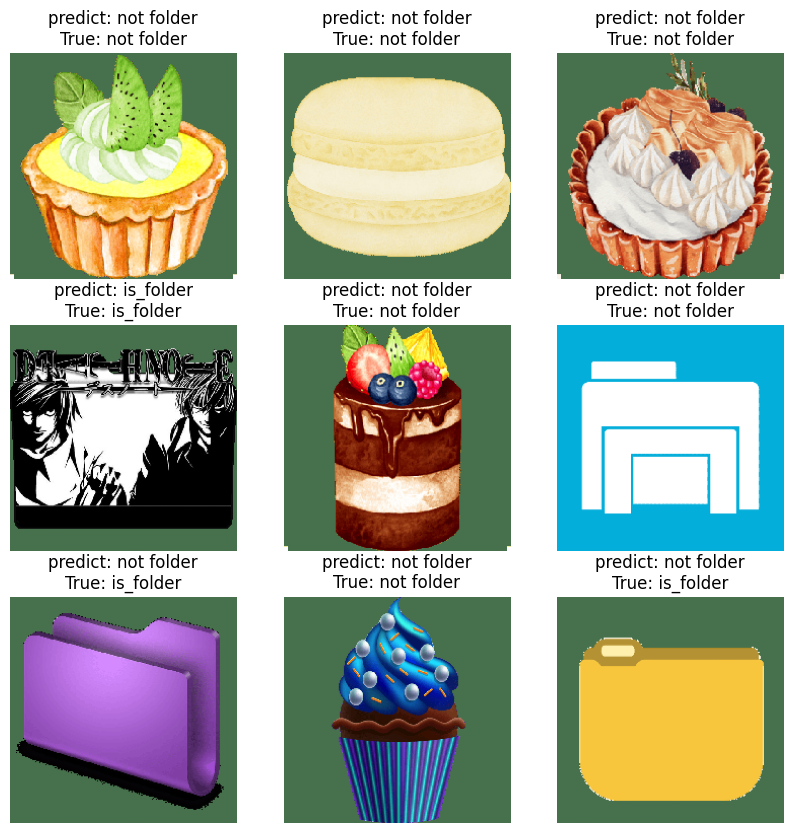

In [30]:
import matplotlib.pyplot as plt
import numpy as np
# 从测试集取一批数据
test_images, test_labels = next(validation_generator)
predictions = model.predict(test_images)
# 显示预测结果
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_images[i])
    pred = "is_folder" if predictions[i] > 0.5 else "not folder"
    true = "is_folder" if test_labels[i] == 1 else "not folder"
    plt.title(f"predict: {pred}\nTrue: {true}")
    plt.axis('off')
plt.show()

打印混淆矩阵

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 49s 5s/step


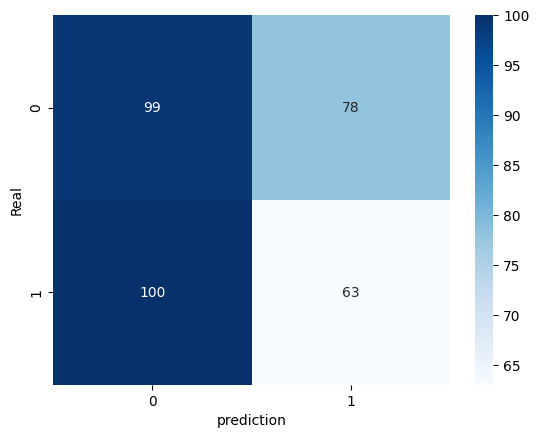

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# 获取所有测试数据预测
y_pred = model.predict(validation_generator)
y_pred = (y_pred > 0.5).astype(int)
y_true = validation_generator.classes
# 绘制混淆矩阵
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('prediction')
plt.ylabel('Real')
plt.show()

现在 模型可以判断如些是标准的文件夹图片